# Quickstart Guide: The Basics

---

Okay, I've installed ``cluster_generator`` and I want to start making clusters for my simulation project... How do I start?

The first thing to decide on is what data we're going to use to generate the galaxy cluster. There are a bunch of ways to make the ``ClusterModel`` class that underlies the ``cluster_generator`` class, but each of the requires at least 1 radial profile representing certain components and variables of the cluster. Radial profiles in ``cluster_generator`` are their own class (``RadialProfile``), and a large variety of them are built into the API. To start off, let's create a basic density profile:

## Profiles

In [1]:
import matplotlib.pyplot as plt

# imports #
import cluster_generator as cg
import numpy as np
# - Constants - #
M0 = 1e14 # The scale mass in Msun
a = 1e3 # scale length in kpc

# creating the radial density profile #
density = cg.radial_profiles.hernquist_density_profile(M0,a)

print(density)

RadialProfile; type=hernquist_density_profile.


Now, ``RadialProfile`` objects like our ``density`` profile are essentially fancy wrappers for simple lambda functions. We can call the function on values or on arrays:

In [2]:
r = np.geomspace(1e-1,1e4,10)
rho = density(r)

print(r,rho)

[1.00000000e-01 3.59381366e-01 1.29154967e+00 4.64158883e+00
 1.66810054e+01 5.99484250e+01 2.15443469e+02 7.74263683e+02
 2.78255940e+03 1.00000000e+04] [1.59107206e+08 4.42380961e+07 1.22751658e+07 3.38158266e+06
 9.07912050e+05 2.22940080e+05 4.11417258e+04 3.68024519e+03
 1.05686232e+02 1.19575464e+00]


You should always remember that ``RadialProfile`` objects don't have implicit units. **You need to use the standard unit system** or your units may be non-standard. 

You can also plot ``RadialProfile`` objects:

(<Figure size 1000x1000 with 1 Axes>, <Axes: xlabel='Radius (kpc)'>)

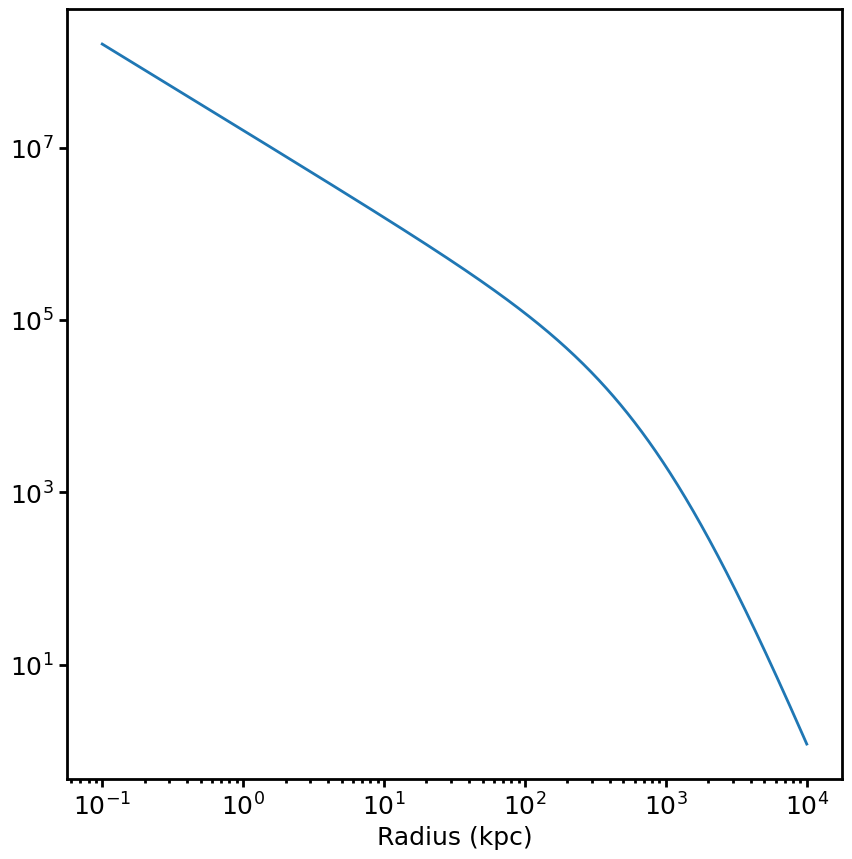

In [3]:
density.plot(1e-1,1e4,1000)

## Creating a Galaxy Cluster

---

Now that we've figured out the radial profiles, its time to build an actual galaxy cluster. In ``cluster_generator``, galaxy clusters are represented by the ``ClusterModel`` class and can be initialized
from a variety of different profiles. The ready to use options are ``ClusterModel.from_dens_and_tden`` which generates from gas density and total density, ``ClusterModel.from_dens_and_temp`` which generates from gas density and temperature, and ``ClusterModel.from_dens_and_entr``, which generates from gas density and entropy. Check out the other quick start guides for a more in-depth description of what goes on under the hood, but for now, lets try to make a viable cluster from gas density and total density:

In [4]:
# Create the radial profiles #
import matplotlib.pyplot as plt
z= 0.1
M200 = 1.5e15
conc = 4.0
r200 = cg.radial_profiles.find_overdensity_radius(M200, 200.0, z=z)
a = r200 / conc
M = cg.radial_profiles.snfw_total_mass(M200, r200, a)
rhot = cg.radial_profiles.snfw_density_profile(M, a)
Mt = cg.radial_profiles.snfw_mass_profile(M, a)
r500, M500 = cg.radial_profiles.find_radius_mass(Mt, z=z, delta=500.0)
f_g = 0.12
rhog = cg.radial_profiles.vikhlinin_density_profile(1.0, 100.0, r200, 1.0, 0.67, 3)
rhog = cg.radial_profiles.rescale_profile_by_mass(rhog, f_g * M500, r500)
rhos = 0.02 * rhot
rmin = 0.1
rmax = 10000.0


# Creating the model 
basic_model = cg.model.ClusterModel.from_dens_and_tden(1,5000,rhog,rhot,stellar_density=rhos,num_points=10000)


cluster_generator : [INFO     ] 2023-08-25 09:06:58,474 Computing the profiles from density and total density. Gravity=Newtonian
cluster_generator : [INFO     ] 2023-08-25 09:06:58,481 Integrating total mass profile.
cluster_generator : [INFO     ] 2023-08-25 09:07:02,756 ClusterModel [ClusterModel object; gravity=Newtonian] has no virialization method. Setting to default = lma
cluster_generator : [INFO     ] 2023-08-25 09:07:02,757 Computing gravitational potential of ClusterModel object; gravity=Newtonian. gravity=Newtonian.
cluster_generator : [INFO     ] 2023-08-25 09:07:14,200 Computing gravitational potential of ClusterModel object; gravity=Newtonian. gravity=Newtonian.
cluster_generator : [INFO     ] 2023-08-25 09:07:26,018 Integrating pressure profile.
cluster_generator : [INFO     ] 2023-08-25 09:08:02,471 ClusterModel [ClusterModel object; gravity=Newtonian] has no virialization method. Setting to default = lma


Now, this step can take a little while because the mathematics under the hood can be a bit hard to perform, but the end result is a ``ClusterModel`` instance which carries all of the data about our cluster. Data regarding the galaxy cluster is stored in what are called ``fields``. The fields of the galaxy cluster can be seen by printing the keys of ``model.fields``:

In [5]:
print(basic_model.fields.keys())

odict_keys(['radius', 'density', 'total_density', 'total_mass', 'gas_mass', 'stellar_density', 'gravitational_potential', 'gravitational_field', 'pressure', 'temperature', 'stellar_mass', 'dark_matter_density', 'dark_matter_mass', 'gas_fraction', 'electron_number_density', 'entropy'])


As you can see, there are a lot of fields that have been generated, not just the ones we originally input into the ``ClusterModel``. All of these are prescribed by hydrostatic equilibrium. If we want to use the data they hold, we can just access the field by its name:

In [6]:
avg = 4*np.pi*np.trapz(basic_model['temperature']*basic_model["density"]*basic_model['radius']**2,basic_model["radius"])/basic_model["gas_mass"][-1]
print(f"The average temperature (spatial) is {avg}.")

The average temperature (spatial) is 6.270685743725246 keV.


Let's get more serious about our cluster. What if we want to make sure its in hydrostatic equilibrium?

cluster_generator : [INFO     ] 2023-08-25 09:08:02,511 The maximum relative deviation of this profile from hydrostatic equilibrium is 4.33609e-07


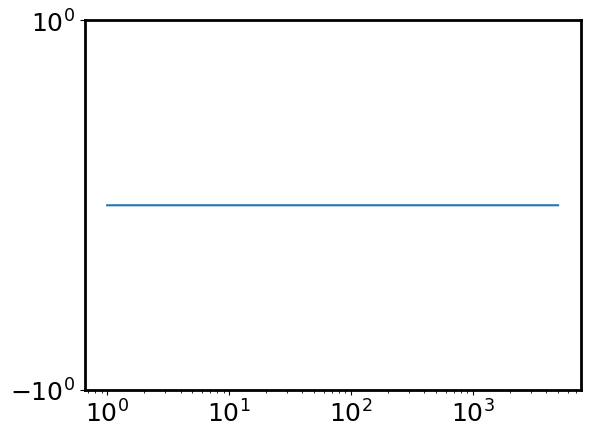

In [7]:
hse_check = basic_model.check_hse()

plt.loglog(basic_model["radius"].d,hse_check)
plt.yscale("symlog")
plt.ylim([-1,1])
plt.show()

Okay, so the cluster we generated is in hydrostatic equilibrium, everything looks great, now what if I want to plot some of the fields? We can either manually plot a field or use the ``.plot`` method to plot a field:

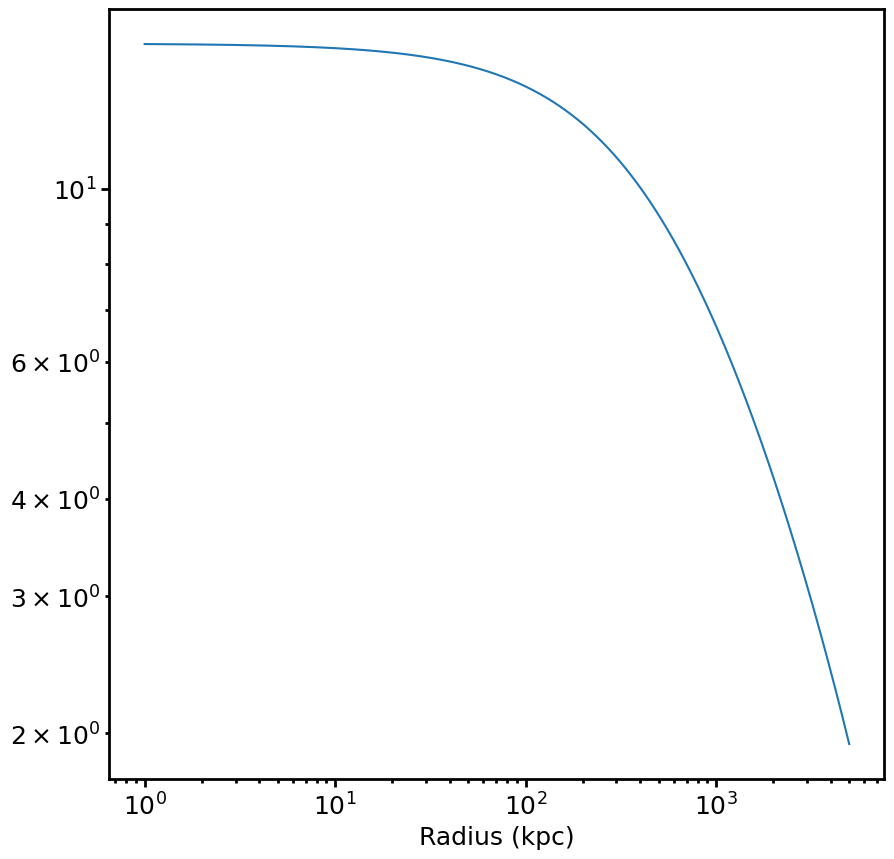

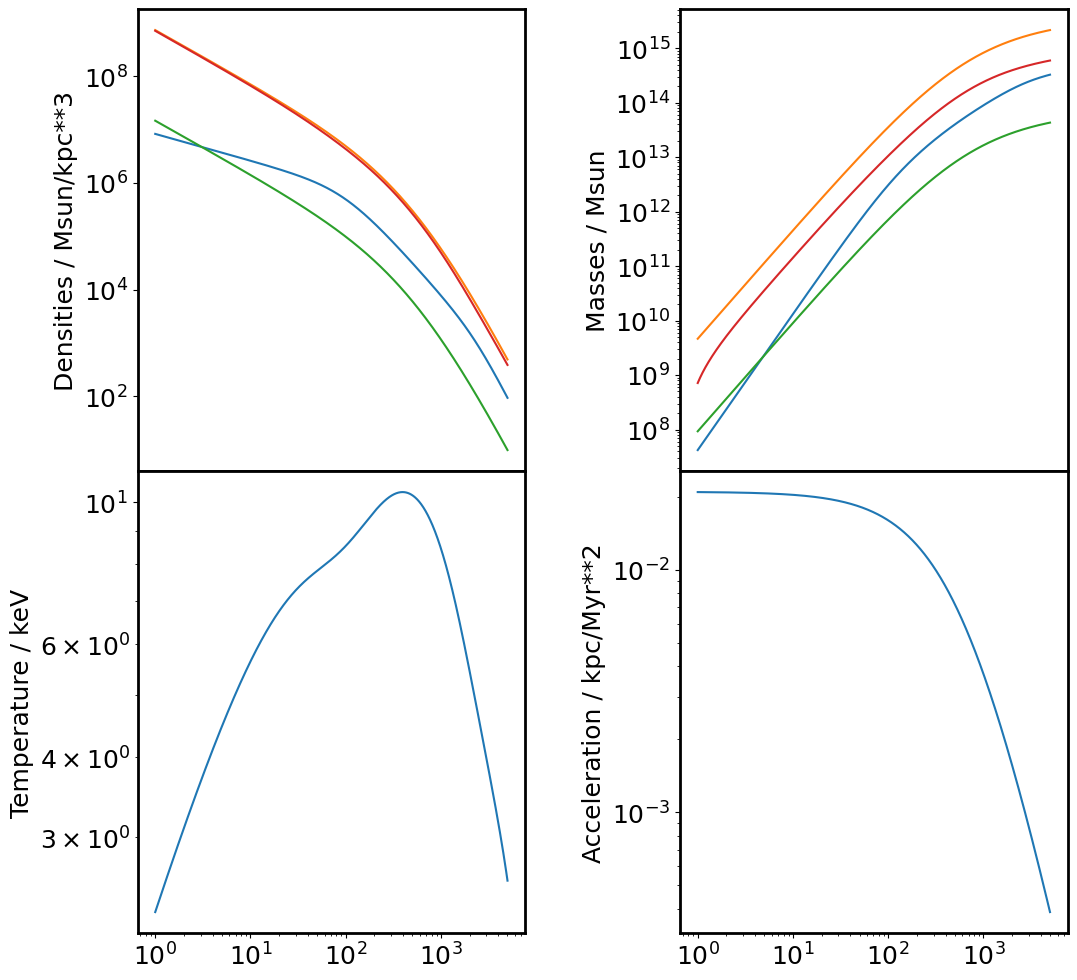

In [8]:
# Really simple example
basic_model.plot("gravitational_potential")

# More complex example #
fig,axes = plt.subplots(2,2,sharex=True,gridspec_kw={"hspace":0,"wspace":0.4},figsize=(12,12))

_fields = [["density","total_density","stellar_density","dark_matter_density"],["gas_mass","total_mass","stellar_mass","dark_matter_mass"],["temperature"],["gravitational_field"]]

for _field_group,ax,lab in zip(_fields,axes.ravel(),["Densities","Masses","Temperature","Acceleration"]):
    for _f in _field_group:
        ax.loglog(basic_model["radius"],np.abs(basic_model[_f]),label=_f)
    
    ax.set_ylabel(f"{lab} / {basic_model[_f].units}")

plt.show()

## Creating Initial Conditions

---

The final basic task is to actually create the initial conditions for your simulation. The ``cluster_generator`` library contains the ``ClusterICs`` class, which wraps one or many of the user's ``ClusterModel`` objects into a single data structure that can then be written to the correct formats for use. To use it, we first have to write our model to disk:

In [14]:
# writing the model to disk
basic_model.write_model_to_h5("basic_model.h5",overwrite=True)

Newtonian


In [15]:
import os
print(f"Basic model files: {[i for i in os.listdir() if 'basic_model' in i]}.")

Basic model files: ['basic_model.h5.pkl', 'basic_model.h5'].


Notice that there are two files: ``name.h5.pkl`` and ``name.h5``. The first of these files contains meta data that is serialized into binary describing any complex data types contained in the ``ClusterModel`` object. The second file ``name.h5`` is an HDF5 file containing all of the raw array data (fields) for the object. Let's make sure we can open it back up again:

In [16]:
reloaded_model = cg.model.ClusterModel.from_h5_file("basic_model.h5")

print(reloaded_model)

cluster_generator : [INFO     ] 2023-08-25 09:10:19,769 Loading ClusterModel instance from basic_model.h5.


ClusterModel object; gravity=Newtonian, fields=['dark_matter_density', 'dark_matter_mass', 'density', 'electron_number_density', 'entropy', 'gas_fraction', 'gas_mass', 'gravitational_field', 'gravitational_potential', 'pressure', 'radius', 'stellar_density', 'stellar_mass', 'temperature', 'total_density', 'total_mass']


Let's get down to business now: now we can create our initial conditions object.

In [12]:
## Create the IC object ##
ics = cg.ics.ClusterICs("test-ics",1,["basic_model.h5"],[0,0,0],[0,0,0],{"dm":100_000})

cluster_generator : [INFO     ] 2023-08-25 09:08:05,726 Loading ClusterModel instance from basic_model.h5.


Anti-climactic right!? Let's see what this object can do. We can generate initial conditions using

In [13]:
cg.codes.setup_ramses_ics(ics)

cluster_generator : [INFO     ] 2023-08-25 09:08:05,778 Loading ClusterModel instance from basic_model.h5.
cluster_generator : [INFO     ] 2023-08-25 09:08:05,810 Loading ClusterModel instance from basic_model.h5.


Computing particle dispersions (LMA) :   0%|          | 0/10000 [00:00<?, ?it/s]

cluster_generator : [INFO     ] 2023-08-25 09:09:29,009 We will be assigning 100000 dark_matter particles.
cluster_generator : [INFO     ] 2023-08-25 09:09:29,011 Compute 100000 particle positions.
cluster_generator : [INFO     ] 2023-08-25 09:09:29,063 Computing dark_matter velocities using lma method.


Generating particle velocities [LMA]:   0%|          | 0/100000 [00:00<?, ?it/s]

Newtonian


cluster_generator : [INFO     ] 2023-08-25 09:09:29,659 Simulation setups saved to Merger_Config.txt.


And you're done! Now you can take your initial conditions to the simulation system of your choice and run it. For more information and additional tutorials, check out the other quickstart guides and the examples.